# Курс «Глубокое обучение в компьютерном зрении»

# Урок 6. Metric learning

## <font color='red'>Практическое задание 6</font>

Обучить сиамскую сеть для верификации лиц на датасете LFW<br>
Библиотеки: [Python, Tensorflow]

Выполнил ___Соковнин ИЛ___

За основу взят файл __6_Embeddings.ipynb__ из 6 занятия.


# Labeled Faces in the Wild (LFW)<br>
http://vis-www.cs.umass.edu/lfw/<br>
https://scikit-learn.org/0.24/datasets/real_world.html#labeled-faces-in-the-wild-dataset

Information:<br>
13233 images<br>
5749 people<br>
1680 people with two or more images

## LFW deep funneled images
`@InProceedings{Huang2012a,`<br>
&nbsp;&nbsp;`author = {Gary B. Huang and Marwan Mattar and Honglak Lee and 
               Erik Learned-Miller},`<br>
&nbsp;&nbsp;`title = {Learning to Align from Scratch},`<br>
&nbsp;&nbsp;`booktitle = {NIPS},`<br>
&nbsp;&nbsp;`year = {2012}`<br>
`}`<br>

In [4]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Загрузка датасета LFW

In [11]:
if 1:
    dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                    fname='lfw',
                                    untar=True )
    data_dir = pathlib.Path(data_dir)
else: 
    data_dir = pathlib.Path('lfw')

180576256/180566744 [==============================] - 2s 0us/step


In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


In [14]:
data_dir

PosixPath('/root/.keras/datasets/lfw')

In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names[:10])

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban']


## Визуализация датасета LFW

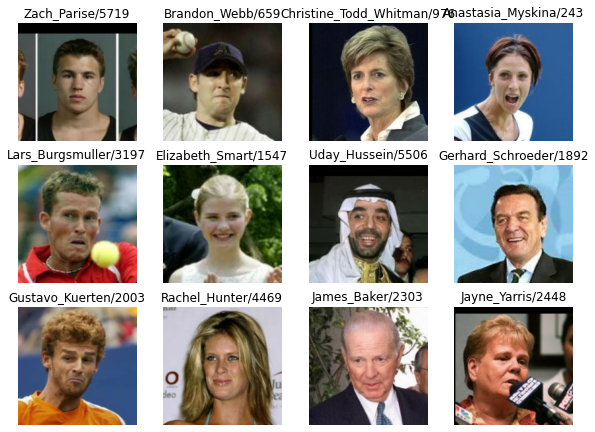

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'{class_names[labels[i]]}/{labels[i]}')
    plt.axis("off")

In [251]:
x_list= [2132, 5230, 2325, 1805,  353, 2941, 1404, 3303, 2970,  561,  461, 2506,
         2473,  595, 4773, 2545, 4789,  210, 2697, 5565, 4963, 1852]
image_list = []

George_W_Bush 1871 0
George_W_Bush 1871 0
George_W_Bush 1871 0


4

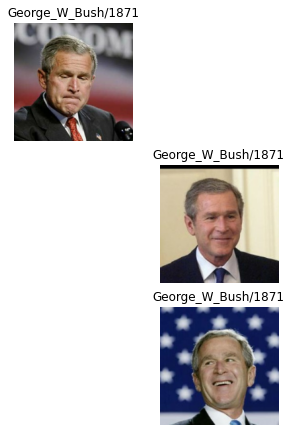

In [211]:
# Отберём картинки для тестирования
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    if labels[i].numpy() in label_list: # 2303 - 'James_Baker':
      print(class_names[labels[i]], labels[i].numpy(), tf.rank(labels[i]).numpy())  # Получить значение и ранг
      image_list.append(images[i])

      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(f'{class_names[labels[i]]}/{labels[i]}')
      plt.axis("off")

len(image_list)


### Подготовка данных.

In [18]:
# BATCH_SIZE = 64
# INP_SIZE = 128


# def prepare(label, img):
#     img = tf.cast(img, tf.float32)/255.
#     return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


# train_ds = train_ds.shuffle(buffer_size=1000)
# train_ds = train_ds.map(prepare)
# train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

# test_ds = test_ds.map(prepare)
# test_ds = test_ds.batch(128, drop_remainder=True)

### Построение модели.

In [44]:
EMB_SIZE = 64
# Хотим получить embeding-вектор размерности dim=64, на выходе нашей сети.

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Спасаемся от переобучения
    
    # В конце нам нужно получить не метку класса,
    # а некоторый вектор размерности 64 (EMB_SIZE=64)
    # Поэтому функция активации не нужна.
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [45]:
# model.summary()  # Error: модель ещё не построена

## Contrastive Loss

Определяется для пары объектов

In [150]:
# MARGIN - условное расстояние,
# на которое мы хотим разнести наши классы в embeding-пространстве
MARGIN = 10.0

# У нас есть embeding-и для цифр (объектов, картинок) и
# правильные ответы - классы (labels)

def contastive_loss(embs, labels):
  try:
    bs = embs.shape[0]  # Наш batchsize, разбиваем его на 2
    embs1 = embs[:bs//2, :]  # 1-я половина embedding-ов (32 вектора)
    embs2 = embs[bs//2:, :]  # 2-я половина embedding-ов (32 вектора)
    
    # То хе самое делаем с классами
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    # Образуем пары (1, 33), (2, 34), ... , (32, 64)
    # Получаем 32 разности векторов, возводим поэлементно в квадрат и
    # суммируем вдоль 1-го измерения (0-е (batch) измерение оставляем как есть)
    # т.е. суммируем по 64 элементам - получаем 32 квадрата расстояний d2
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    # Получаем batch из 32 расстояний
    d =  tf.sqrt(d2)
    
    # Индикатор z показывает близки 2 объекта в паре или далеки
    # Если объекты принадлежат 1 классу они близки
    z = tf.cast(labels1 == labels2, tf.float32)  # Список из 32 bool-ан значений (true/false)
    # z = 1 или 0 (z - 32d-вектор)
  except Exception as ex:
    print('>',embs1)
    print('>',embs2)
    print(ex)
    
    # Получаем 32 значения для contastive loss для каждой из пар
    # И усредняя по batch-у получаем скаляр, 
    # который характеризует contastive loss для целого batch-а
  return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)  

## Подготовка к обучению

In [151]:
BATCH_SIZE = 32
NUM_EPOCHS = 3

In [152]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [153]:
%%time
for epoch in range(NUM_EPOCHS):
    for iteration, (images, labels) in enumerate(train_ds):
        if(len(labels)%2 > 0): # на последней операции в эпохе возникает ошибка.  из-за того что к-во элементов в батче не четное. 
                labels = labels[:-1]
                images = images[:-1]
        # Forward
        with tf.GradientTape() as tape:
            embs = model(images)
            loss_value = contastive_loss(embs, labels)
            
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 100 == 0:
            print('[{}/{}] Loss: {}'.format(epoch,iteration, loss_value.numpy()))

[0/0] Loss: 12.51218318939209
[0/100] Loss: 0.0
[0/200] Loss: 0.0
[0/300] Loss: 0.0
[1/0] Loss: 0.0
[1/100] Loss: 0.0
[1/200] Loss: 2.1252598762512207
[1/300] Loss: 0.14804311096668243
[2/0] Loss: 0.0
[2/100] Loss: 0.0
[2/200] Loss: 0.15885543823242188
[2/300] Loss: 0.0
CPU times: user 1min 17s, sys: 3.96 s, total: 1min 21s
Wall time: 1min 24s


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 256)               3

## Получение эмбеддингов для тестовой выборки

In [154]:
images, labels = next(iter(val_ds))

In [155]:
%%time

test_embs=[]
test_labels = []
for iteration, (images, labels) in enumerate(val_ds):
    for label in labels.numpy():
        test_labels.append(label) 
    embs = model(images)
    for emb in embs.numpy():
        test_embs.append(emb)

test_labels = np.array(test_labels)
test_embs = np.array(test_embs)


CPU times: user 4.9 s, sys: 268 ms, total: 5.17 s
Wall time: 3.2 s


In [160]:
test_lbl_count = {}
for i in test_labels:
    name = class_names[i]
    if name in test_lbl_count:
        test_lbl_count[name] += 1
    else:
        test_lbl_count[name] = 1

In [161]:
test_lbl_count = list(test_lbl_count.items())
test_lbl_count = sorted(test_lbl_count, key=lambda x:x[1], reverse=True)
top_10 = test_lbl_count[:10]
top_10

[('George_W_Bush', 121),
 ('Colin_Powell', 50),
 ('Tony_Blair', 32),
 ('Donald_Rumsfeld', 29),
 ('Gerhard_Schroeder', 23),
 ('Junichiro_Koizumi', 19),
 ('Hugo_Chavez', 14),
 ('Jean_Chretien', 13),
 ('Serena_Williams', 12),
 ('Lleyton_Hewitt', 12)]

## Функция для визуализации эмбеддингов

Используем TSNE

In [162]:
# Для визуализации многомерных объектов в 2d-пространстве.
# Алгоритм TSNE нелинейно отображает Nd-вектоа в 2d-вектора с сохранением свойства близости.
# Это embedding многомерного объекта в низкоразмерное пространство.
from sklearn.manifold import TSNE

In [163]:
def draw_embeddings(X_embedded, targets, labels):
    # Визуализация
    # 
    # labels - метки для отрисовки
    # targets - правильные ответы (0, 1)
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [165]:
# Отберём ембединги с метками соответствующими label_list
label_list = [1868, 1869, 1870, 1871, 1875, 1877, 1879, 1882, 1883, 1884, 1885, 1889, 1892, 1898, 1903, 1904, 1906]
test_embs_v = []
test_labels_v = []

for i in range(1, len(test_labels)):
  if test_labels[i] in label_list:
    test_labels_v.append(test_labels[i])
    test_embs_v.append(test_embs[i])

test_labels_v = np.array(test_labels_v)
test_embs_v = np.array(test_embs_v)

In [166]:
print(len(set(test_labels_v)))
print(len(test_labels_v))
len(label_list)

17
162


17

In [167]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:len(test_labels_v)])
labels_for_viz = test_labels_v[:len(test_labels_v)]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


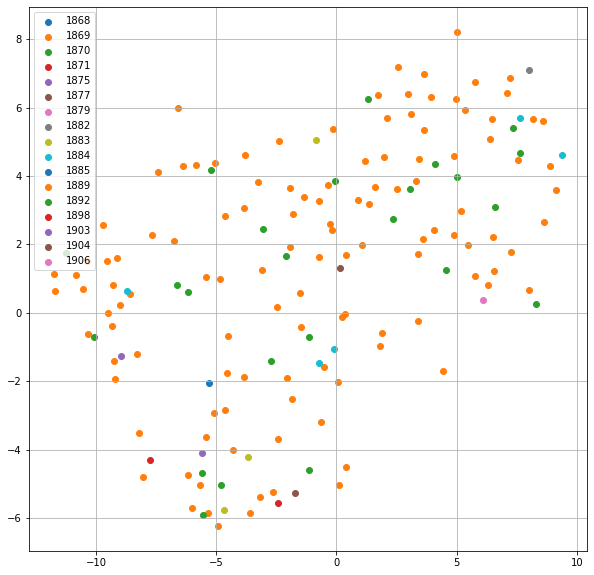

In [169]:
# Пространство embedding_ов
draw_embeddings(test_embs_2D, labels_for_viz, label_list)

Результат не очень впечатляет. Требуется дообучить и доработать модель.

# Тестирование на новых данных

In [231]:
images, labels = next(iter(val_ds))

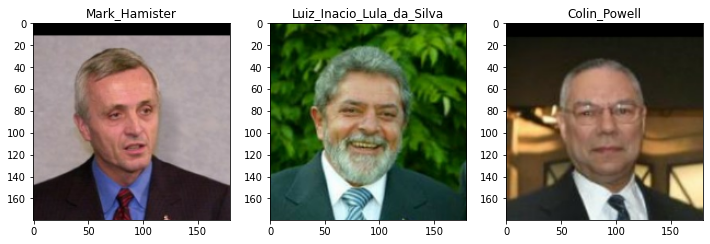

In [232]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    ax[i].imshow(images[i].numpy().astype("uint8"))
    ax[i].set_title(class_names[labels[i].numpy()])
plt.show()

## Получение эмбеддингов для новых данных

In [239]:
new_embs = model(np.stack(images[:3], axis=0))

## Вычисление расстояний между эмбеддингами

In [240]:
# Посчитаем евклидово расстояние между векторами
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

# Расстояние м/д всеми большое. Это разные личности.

A1 <-> A2:  37.096277293853895
A2 <-> B1:  29.436802298990354
A1 <-> B1:  36.901093125111146


In [241]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3552, 3401, 1047, 2920,  598,  425, 2816, 5481, 2741, 5710, 2288,
       2055,    9, 1871, 5177, 4592, 1047,  531, 5538, 4503, 4707, 4878,
        738,  321, 4853, 4963,  127, 4572, 1047,  464,  747, 5408],
      dtype=int32)>

# Ещё одна проверка

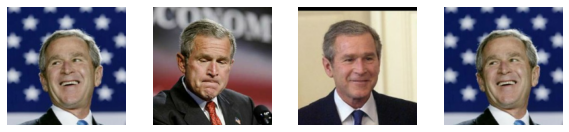

In [248]:
plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_list[i].numpy().astype("uint8"))
  plt.axis("off")

## Вычисление расстояний между эмбеддингами

In [249]:
new_embs = model(np.stack(image_list[:4], axis=0))

In [250]:
# Посчитаем евклидово расстояние между векторами
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]

print('A1 <-> A4: ', diff(emb1, emb4))
print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A2 <-> A4: ', diff(emb2, emb4))
print('A3 <-> A4: ', diff(emb3, emb4))

A1 <-> A4:  0.0
A1 <-> A2:  48.520465740789476
A1 <-> A3:  62.857512633982346
A2 <-> A3:  30.196184697946528
A2 <-> A4:  48.520465740789476
A3 <-> A4:  62.857512633982346


Расстояние м/д всеми большое.<br>Модель считает, что это разные личности, хотя это один человек (George_W_Bush 1871).

Модель надо дорабатывать и дообучать

In [ ]:
# Расстояние м/д всеми большое. Это разные личности